### Reproduction du tutoriel de Katherine Bailey
Ce notebook tente de reproduire le [tutoriel de Katherine Bailey](https://katbailey.github.io/post/gaussian-processes-for-dummies/) et d'étendre la présentation à différents noyaux de var-covar. 
Ce notebook est créé après la lecture du [papier de Brochu, Cora, Freitas (2010)](https://arxiv.org/abs/1012.2599) et grâce aux aides du site de .

On génère 50 $x_i$  sur l'intervalle $[0,5]$ et on génère les $(y_i)_i$ tels que: 
$$ y_i = \sin(x_i)  + \sigma\ \eta_i =f(X_i)  + \sigma\ \eta_i \text{ avec } \eta_i \sim \mathcal{N}(0,1)$$
On met un prior sur f : un processus gaussien. Ce processus gaussien peut-être samplé comme décrit ci-dessous. Il peut aussi, pour chaque nouveau $x_{t+1}$, donner la moyenne de la valeur de la fonction estimée et la std de cette valeur en ce nouveau point. 
$$ f_{t}= [f(x_1) ... f(x_t)] ??$$
On définit également la fonction kernel par le noyau exponentiel au carré (squared exponential kernel)

In [1]:
import numpy as np
X=np.linspace(0,5,50)
Y= np.sin(X)

def kernel(x1,x2, param = 1):
    ### Squared exponential kernel avec un paramètre de mise à l'échelle param
    return np.exp(-0.5*np.square((x1-x2[:,np.newaxis])/param))

def update_join_distr(x_t, x_new, K, param=1):
    ### Màj des paramètres de la loi jointe
    k= kernel(x_t,x_new,param)
    K=np.concatenate((K,k))
    v=np.append(k,1).reshape(-1,1)
    K=np.concatenate((K,v),axis=1)
    return(K,k)


### TRES IMPORTANT ! Pour sampler, on a besoin d'utiliser la décomposition de Cholesky Sigma = L L^T
### Puis on ajoute la nouvelle moyenne + L*N(0,1) Pour avoir un sample suivant la loi a posteriori ! 
### Celà est différent de calculer la moyenne exacte qui donne une estimation de la valeur de la fonction objective
### et non un échantillon provenant de la distribution ! 

def compute_cond_distr(x_new,k, K,f_t):
    #Calcul de la moyenne et de la std de la loi conditionnelle pour l'observation x_new 
    tmp = np.matmul(k, np.linalg.inv(K))
    mu_t_x_new= np.matmul(tmp, f_t)
    sigma_t_x_new = 1 - np.matmul(tmp,k.T)
    return mu_t_x_new, sigma_t_x_new

On sait que pour un nouveau $x_{t+1}$la loi jointe avec $x_{1:t}$ est donnée par : 
$$
a  a\\
$$
La loi conditionnelle est donnée par
$$ 
p(y_{t+1}| \mathcal{D}_t, x_{t+1}) = \mathcal{N}\left(\mu_t ( x_{t+1}) , \sigma^2_t(x_{t+1})\right)\\
\mu_t ( x_{t+1}) = k^T K^{-1} f_{1:t} \text{ avec } k^T := [\kappa(x_{t+1},x_1),...,\kappa(x_{t+1},x_t)]\\
\sigma^2_t( x_{t+1}) = \kappa(x_{t+1},x_{t+1}) - k^T K^{-1} k
$$

Inverser une matrice n'est jamais vraiment souhaitable, on utilisa à la place des résolutions d'équations linéaires, plus rapides et plus précises.
On rappelle la décomposotion de Cholesky. Soit M une matrice symétrique définie positive. Alors il existe $L$ une matrice triangulaire inférieure telle que : 
$$ \mathrm{K} = \mathrm{L} \mathrm{L}^T $$
$$  \mu = k^T K^{-1} f_{1:t} = k^T (L L^T)^{-1} f_{1:t}\\
= k^T (L^T)^{-1} L^{-1} f_{1:t}\\
= (L^{-1} k)^T L^{-1} f_{1:t} $$  
En remarquant que K inversible $\Leftrightarrow	$ L inversible ( $\det(K) = \det(L)\det(L^T)$)  et  $L^{-1} k = x \Leftrightarrow k = L x$
On a alors 
$$ \mu = L_k^T L_y $$ avec $L_k$ solution de $ L x = k$ et $L_y $ solution de l'équation $ L x = f_{1:t} $ 

De même 
$$
\sigma = \kappa(x_{t+1}, x_{t+1}) - k^T K^{-1}k\\
= \kappa(x_{t+1}, x_{t+1}) - (L^{-1}k)^T L^{-1}k
$$

In [2]:
def compute_cond_distr(x, y, x_new):
    #Sans erreur i.e : y_t = f(x_t) sans bruit
    #Calcul de la moyenne et de la std de la loi conditionnelle pour l'observation x_new 
    k= kernel(x_new,x)
    L = np.linalg.cholesky(kernel(x,x)+ 0.001*np.eye(x.shape[0]))
    Lk = np.linalg.solve(L,k)
    Ly = np.linalg.solve(L,y)
    mu = np.dot(Lk.T, Ly)
    sigma = kernel(x_new, x_new) - np.dot(Lk.T, Lk)
    return mu, sigma

In [3]:
####TEST DES FONCTIONS POUR DES VALEURS QUELCONQUES

n_obs = 5
x     = np.random.uniform(low=0,high=5, size=n_obs)
y     = np.sin(x)

n_newobs    = 40
x_new = np.linspace(0,5, n_newobs)

mu, sigma = compute_cond_distr(x,y, x_new)

print(mu.shape)
print(sigma.shape)

(40,)
(40, 40)


### Sampling from the posterior

On veut maintenant échantilloner selon la loi postérior.

In [4]:
n_posterior_samples = 3
echantillon = mu + np.sqrt(np.diag(sigma)) * np.random.randn(n_posterior_samples,n_newobs)

In [5]:
from matplotlib import pyplot as plt 

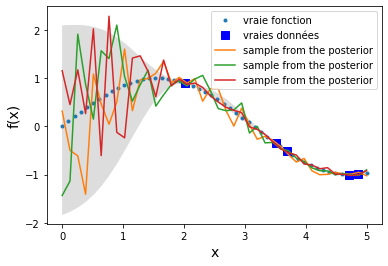

In [7]:
plt.plot(X,Y,'.', label="vraie fonction")
plt.plot(x,y, 'bs', ms=8,label= "vraies données")
plt.plot(x_new[:,np.newaxis], echantillon.T, label="sample from the posterior")
plt.gca().fill_between(x_new.flat, mu-2*np.diag(sigma), mu+2*np.diag(sigma), color="#dddddd")
plt.xlabel("x",fontsize=14)
plt.ylabel('f(x)',fontsize=14)
plt.legend()